In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import random

# Bibliotecas do PyTorch Forecasting
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer

# Configurações de exibição
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

# ==========================================
# 1. CONFIGURAÇÕES E CAMINHOS
# ==========================================
# Ajuste conforme seu ambiente (Colab ou Kaggle)
# Se for Colab:
DATA_PATH = "../data/processed/dataset_tft_completo.parquet"
CHECKPOINT_DIR = "../src/models/checkpoints"

# Se for Kaggle (descomente abaixo):
# DATA_PATH = "/kaggle/input/dengue-dataset/dataset_tft_completo.parquet" # Ou /kaggle/working/...
# CHECKPOINT_DIR = "/kaggle/working/models/checkpoints/"

BATCH_SIZE = 64

# --- Definição das Variáveis (Deve ser IGUAL ao treino) ---
TARGETS = ["R0", "peak_week", "log_total_cases", "alpha", "beta"]

TIME_VARYING_KNOWN_REALS = [
    "time_idx", "week_cycle", "sin_week_cycle", "cos_week_cycle", "log_pop",
    "forecast_temp_med", "forecast_precip_tot"
]

TIME_VARYING_UNKNOWN_REALS = [
    "casos", "incidence",
    "temp_med", "precip_med", "rel_humid_med",
    "enso", "iod",
    "tda_entropy_H1", "tda_amplitude_H1"
]

STATIC_CATEGORICALS = ["uf", "koppen", "biome", "macroregion_name"]
STATIC_REALS = ["num_neighbors"]

# ==========================================
# 2. FUNÇÕES DE CARREGAMENTO
# ==========================================
def load_data():
    print(f"⏳ Carregando dados de: {DATA_PATH}")
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Arquivo não encontrado: {DATA_PATH}")

    data = pd.read_parquet(DATA_PATH)

    # Garantir Tipos
    data["time_idx"] = data["time_idx"].astype(int)
    data["geocode"] = data["geocode"].astype(str)
    for col in STATIC_CATEGORICALS:
        if col in data.columns:
            data[col] = data[col].astype(str)

    # Limpeza de NaNs (Crítico para inferência)
    cols_check = TARGETS + TIME_VARYING_UNKNOWN_REALS + TIME_VARYING_KNOWN_REALS
    cols_check = [c for c in cols_check if c in data.columns]
    data = data.dropna(subset=cols_check)

    print(f"✅ Dados carregados. Total linhas: {len(data)}")
    return data

def get_best_checkpoint():
    # Encontra o arquivo .ckpt mais recente na pasta
    if not os.path.exists(CHECKPOINT_DIR):
        raise FileNotFoundError(f"Pasta de checkpoints não encontrada: {CHECKPOINT_DIR}")

    checkpoints = [os.path.join(CHECKPOINT_DIR, f) for f in os.listdir(CHECKPOINT_DIR) if f.endswith(".ckpt")]
    if not checkpoints:
        raise FileNotFoundError("Nenhum arquivo .ckpt encontrado na pasta!")

    latest_ckpt = max(checkpoints, key=os.path.getctime)
    print(f"🏆 Checkpoint selecionado: {latest_ckpt}")
    return latest_ckpt

# ==========================================
# 3. PREPARAÇÃO DO DATALOADER
# ==========================================
def prepare_dataloader(data):
    print("🛠️ Recriando TimeSeriesDataSet (Validação)...")

    # Definir corte de tempo (Último ano para teste)
    max_prediction_length = 1
    max_encoder_length = 52
    training_cutoff = data["time_idx"].max() - max_prediction_length

    # Normalizadores (Iguais ao treino)
    target_normalizer = MultiNormalizer([
        GroupNormalizer(groups=["geocode"], transformation="softplus"), # R0
        GroupNormalizer(groups=["geocode"], transformation="softplus"), # peak_week
        GroupNormalizer(groups=["geocode"], transformation=None),       # log_total_cases
        GroupNormalizer(groups=["geocode"], transformation="logit"),    # alpha
        GroupNormalizer(groups=["geocode"], transformation="softplus")  # beta
    ])

    # 1. Recriar o Dataset de Treino (apenas a estrutura, para ajustar os encoders)
    # Isso é necessário para que o modelo saiba como transformar os dados novos igual aos antigos
    training_dataset = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target=TARGETS,
        group_ids=["geocode"],
        min_encoder_length=20,
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=STATIC_CATEGORICALS,
        static_reals=STATIC_REALS,
        time_varying_known_reals=TIME_VARYING_KNOWN_REALS,
        time_varying_unknown_reals=TIME_VARYING_UNKNOWN_REALS,
        allow_missing_timesteps=True,
        target_normalizer=target_normalizer,
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

    # 2. Criar Dataset de Validação (Onde faremos o teste)
    validation = TimeSeriesDataSet.from_dataset(
        training_dataset,
        data,
        predict=True,
        stop_randomization=True
    )

    dataloader = validation.to_dataloader(
        train=False,
        batch_size=BATCH_SIZE * 2,
        num_workers=0 # Use 2 no Colab/Linux, 0 no Windows
    )

    return dataloader

# ==========================================
# 4. FUNÇÕES DE MÉTRICAS E PLOT
# ==========================================
def richards_curve_diff(t, L, t_peak, alpha, beta):
    """Reconstrói a curva de incidência (novos casos)."""
    t = np.array(t)
    b = beta * alpha
    c = 1
    exponent = np.clip(b * (t - t_peak), -50, 50)
    denom = (1 + c * np.exp(exponent))
    J_t = L * (denom ** (-1 / alpha))
    incidence = np.diff(J_t, prepend=J_t[0])
    return incidence

def evaluate_model(model, dataloader):
    print("🔮 Gerando previsões (Inference)...")

    # Previsão
    raw_predictions = model.predict(dataloader, mode="prediction", return_x=True, return_y=True)
    preds = raw_predictions.output
    targets = raw_predictions.y

    print("\n📊 MÉTRICAS POR TARGET:")
    results = []

    for i, name in enumerate(TARGETS):
        y_pred = preds[i].cpu().numpy().flatten()
        y_true = targets[0][i].cpu().numpy().flatten()

        # Desfazer Log do Total Cases
        if "log_total_cases" in name:
            y_pred = np.expm1(y_pred)
            y_true = np.expm1(y_true)
            metric_name = "Total Cases (Real Scale)"
        else:
            metric_name = name

        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"  🔹 {metric_name:<25} | MAE: {mae:.4f} | R²: {r2:.4f}")
        results.append((y_pred, y_true))

    return preds, targets, raw_predictions.x

def plot_random_examples(preds, targets, x_data, n=3):
    print(f"\n📸 Gerando {n} reconstruções de curva aleatórias...")

    total_samples = len(preds[0])
    indices = random.sample(range(total_samples), n)

    weeks = np.arange(1, 53)

    for idx in indices:
        # Extrair parâmetros previstos e reais
        # Índices em TARGETS: 0:R0, 1:Peak, 2:LogTotal, 3:Alpha, 4:Beta
        p_R0 = preds[0][idx].item()
        p_peak = preds[1][idx].item()
        p_L = np.expm1(preds[2][idx].item())
        p_alpha = preds[3][idx].item()
        p_beta = preds[4][idx].item()

        t_R0 = targets[0][0][idx].item()
        t_peak = targets[0][1][idx].item()
        t_L = np.expm1(targets[0][2][idx].item())
        t_alpha = targets[0][3][idx].item()
        t_beta = targets[0][4][idx].item()

        # Reconstruir curvas
        curve_pred = richards_curve_diff(weeks, p_L, p_peak, p_alpha, p_beta)
        curve_true = richards_curve_diff(weeks, t_L, t_peak, t_alpha, t_beta)

        # Plot
        plt.figure(figsize=(12, 5))
        plt.plot(weeks, curve_true, 'k--', alpha=0.5, label=f'Real (R0={t_R0:.2f})')
        plt.plot(weeks, curve_pred, 'r-', linewidth=2, label=f'Previsto (R0={p_R0:.2f})')
        plt.title(f"Amostra {idx} | Pico Real: SE{t_peak:.1f} vs Prev: SE{p_peak:.1f}")
        plt.xlabel("Semana Epidemiológica")
        plt.ylabel("Casos")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()



⏳ Carregando dados de: ../data/processed/dataset_tft_completo.parquet
✅ Dados carregados. Total linhas: 1321777
🛠️ Recriando TimeSeriesDataSet (Validação)...
🏆 Checkpoint selecionado: ../src/models/checkpoints\tft-epoch=03-val_loss=1.92.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


🔮 Gerando previsões (Inference)...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



📊 MÉTRICAS POR TARGET:
  🔹 R0                        | MAE: 0.2466 | R²: 0.4717
  🔹 peak_week                 | MAE: 2.7409 | R²: 0.3850
  🔹 Total Cases (Real Scale)  | MAE: 597.1102 | R²: 0.4898
  🔹 alpha                     | MAE: 0.0628 | R²: 0.4138
  🔹 beta                      | MAE: 0.0749 | R²: 0.4776

📸 Gerando 3 reconstruções de curva aleatórias...


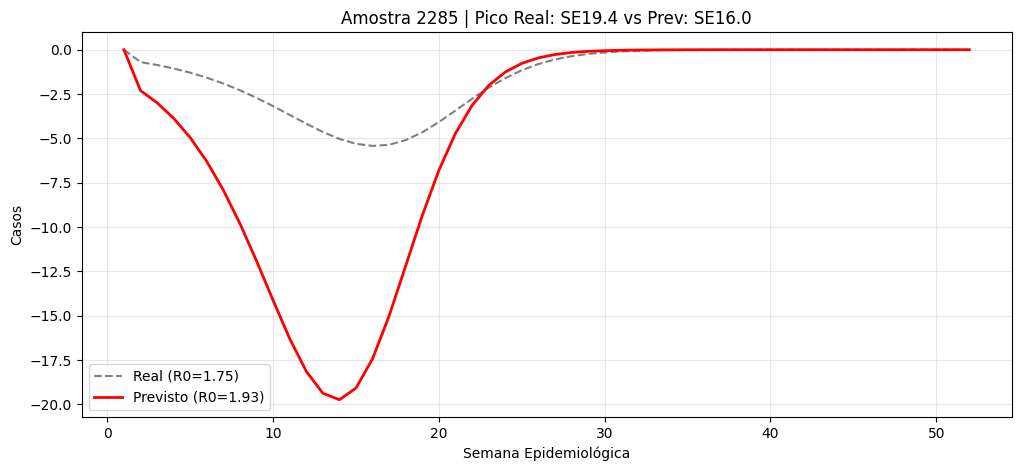

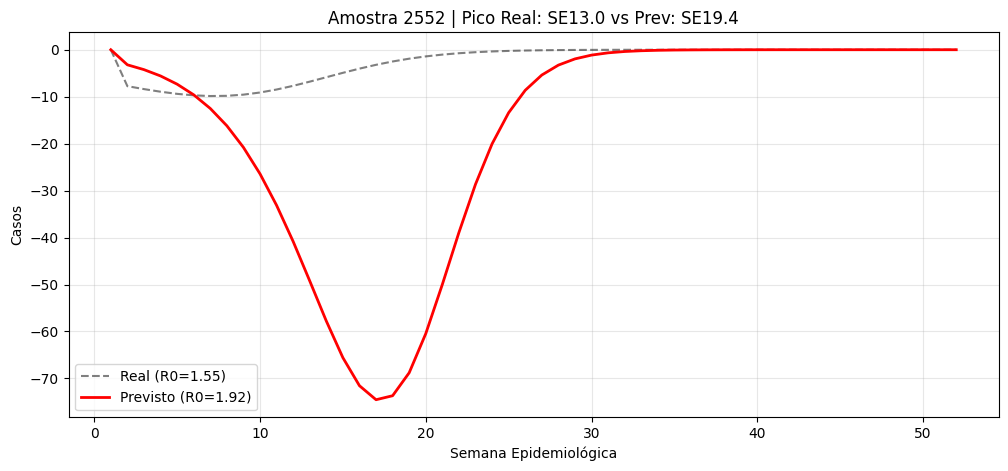

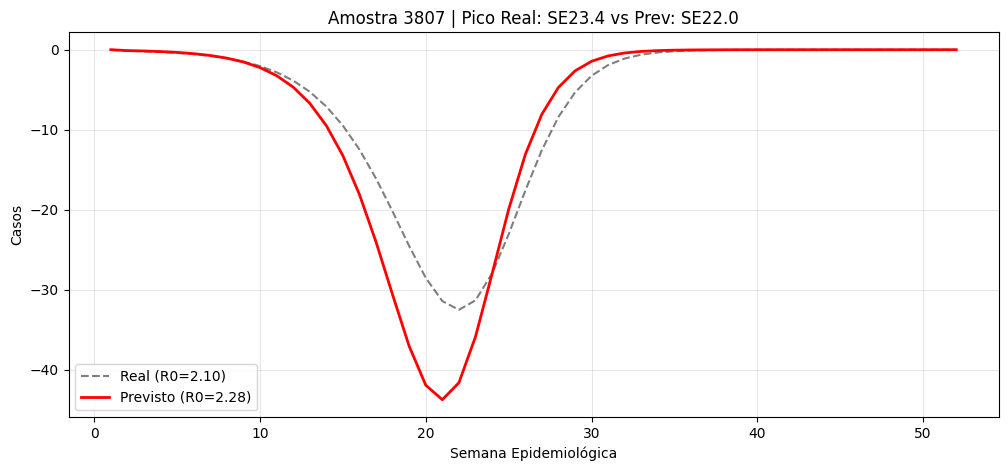

In [2]:
data = load_data()
val_dataloader = prepare_dataloader(data)

# 2. Modelo
ckpt_path = get_best_checkpoint()

# Carregamento seguro para PyTorch 2.6+
best_tft = TemporalFusionTransformer.load_from_checkpoint(
    ckpt_path,
    map_location="cpu",
    weights_only=False
)

# 3. Avaliação
predictions, ground_truth, x_data = evaluate_model(best_tft, val_dataloader)

# 4. Plots
plot_random_examples(predictions, ground_truth, x_data)

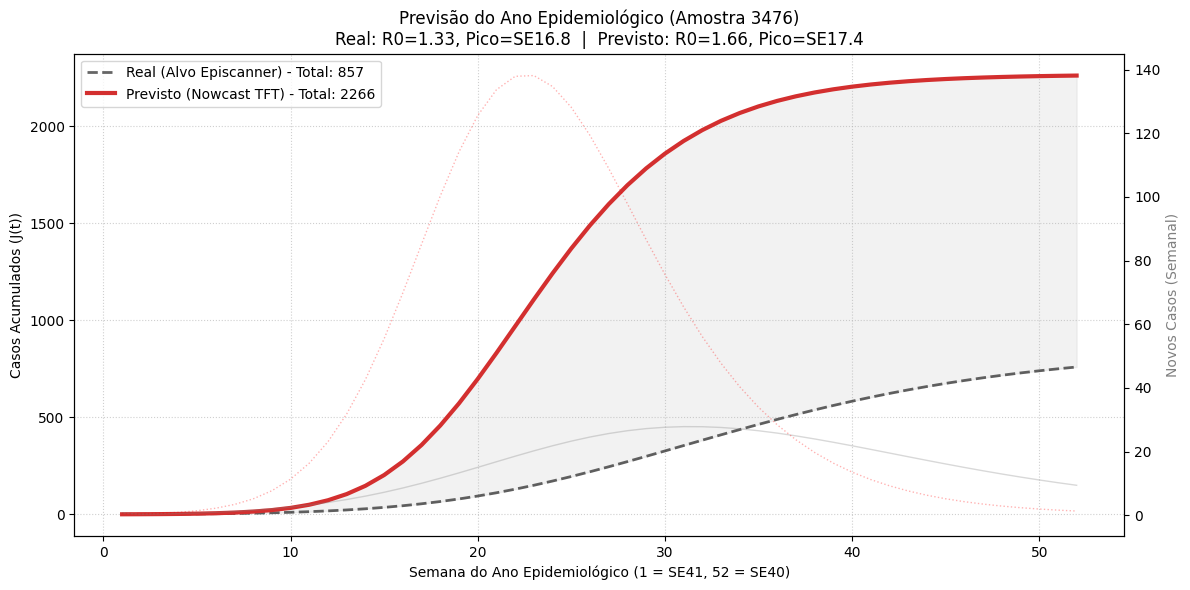

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def richards_cumulative(t, L, t_peak, alpha, beta):
    """
    Calcula a função J(t) (Casos Acumulados) baseada na Eq. de Richards.
    """
    # ... (conversões de tensor para item continuam iguais) ...
    if isinstance(t_peak, torch.Tensor): t_peak = t_peak.item()
    if isinstance(L, torch.Tensor): L = L.item()
    if isinstance(alpha, torch.Tensor): alpha = alpha.item()
    if isinstance(beta, torch.Tensor): beta = beta.item()

    t = np.array(t)

    b = beta * alpha
    c = 1.0

    # --- CORREÇÃO AQUI: SINAL NEGATIVO ---
    # Para crescimento logístico, o expoente deve ser negativo em relação ao tempo.
    # Quando t aumenta, exp diminui, denominador vai pra 1, J(t) vai pra L.
    exponent = -b * (t - t_peak)  # <--- Adicionado o sinal de menos (-)

    exponent = np.clip(exponent, -100, 100)

    denom = 1 + c * np.exp(exponent)
    J_t = L * (denom ** (-1.0 / alpha))

    return J_t

def plot_epidemic_year_prediction(idx, preds, targets, target_names, show_incidence=False):
    """
    Plota a curva acumulada prevista vs real para um ano epidemiológico específico.

    Args:
        idx (int): Índice da amostra no dataset de validação.
        preds (list of tensors): Saída do modelo (raw_predictions.output).
        targets (list of tensors): Alvos reais (raw_predictions.y).
        target_names (list): Nomes das variáveis na ordem correta.
        show_incidence (bool): Se True, plota também a curva de novos casos (derivada).
    """
    # 1. Extrair Parâmetros (Previstos e Reais)
    params_p = {}
    params_t = {}

    # Mapear os valores baseados na ordem da lista TARGETS
    for i, name in enumerate(target_names):
        p_val = preds[i][idx].item()
        t_val = targets[0][i][idx].item() # targets[0] pois é uma lista de tuplas

        if "log_total_cases" in name:
            params_p['L'] = np.expm1(p_val) # Reverter Log
            params_t['L'] = np.expm1(t_val)
        elif "peak_week" in name:
            params_p['tp'] = p_val
            params_t['tp'] = t_val
        elif "alpha" in name:
            params_p['a'] = p_val
            params_t['a'] = t_val
        elif "beta" in name:
            params_p['b'] = p_val
            params_t['b'] = t_val
        elif "R0" in name:
            params_p['R0'] = p_val
            params_t['R0'] = t_val

    # 2. Gerar Eixo Temporal do Ano Epidemiológico (Semana 1 a 52)
    weeks = np.arange(1, 53)

    # 3. Calcular as Curvas (Acumuladas)
    curve_pred = richards_cumulative(weeks, params_p['L'], params_p['tp'], params_p['a'], params_p['b'])
    curve_true = richards_cumulative(weeks, params_t['L'], params_t['tp'], params_t['a'], params_t['b'])

    # 4. Plotagem
    fig, ax = plt.subplots(figsize=(12, 6))

    # Curvas Acumuladas
    ax.plot(weeks, curve_true, color='black', linestyle='--', linewidth=2, alpha=0.6, label=f"Real (Alvo Episcanner) - Total: {int(params_t['L'])}")
    ax.plot(weeks, curve_pred, color='#D32F2F', linewidth=3, label=f"Previsto (Nowcast TFT) - Total: {int(params_p['L'])}")

    # Área sombreada para destacar a diferença de volume
    ax.fill_between(weeks, curve_true, curve_pred, color='gray', alpha=0.1)

    # 5. Anotações e Estilo
    title = f"Previsão do Ano Epidemiológico (Amostra {idx})\n"
    subtitle = (f"Real: R0={params_t['R0']:.2f}, Pico=SE{params_t['tp']:.1f}  |  "
                f"Previsto: R0={params_p['R0']:.2f}, Pico=SE{params_p['tp']:.1f}")

    ax.set_title(title + subtitle, fontsize=12)
    ax.set_xlabel("Semana do Ano Epidemiológico (1 = SE41, 52 = SE40)", fontsize=10)
    ax.set_ylabel("Casos Acumulados (J(t))", fontsize=10)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend(loc='upper left')

    # (Opcional) Plotar Incidência (Novos Casos) em eixo secundário
    if show_incidence:
        ax2 = ax.twinx()
        inc_pred = np.diff(curve_pred, prepend=0)
        inc_true = np.diff(curve_true, prepend=0)
        ax2.plot(weeks, inc_true, color='grey', alpha=0.3, linewidth=1)
        ax2.plot(weeks, inc_pred, color='red', alpha=0.3, linewidth=1, linestyle=':')
        ax2.set_ylabel("Novos Casos (Semanal)", color='grey')

    plt.tight_layout()
    plt.show()

# --- EXEMPLO DE USO ---
# Rode isso depois de gerar as previsões com:
# raw_predictions = best_tft.predict(..., return_x=True, return_y=True)

import random
# Escolhe um exemplo aleatório para plotar
idx_teste = random.randint(0, len(predictions[0])-1)

plot_epidemic_year_prediction(
    idx_teste,
    preds=predictions,        # Output do modelo
    targets=ground_truth,     # Alvos reais
    target_names=TARGETS,     # Lista de nomes: ["R0", "peak_week", ...]
    show_incidence=True       # True mostra também a curva de casos semanais
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🔮 Gerando previsões com índices (Inference)...

📊 MÉTRICAS POR TARGET:
  🔹 R0                        | MAE: 0.2466 | R²: 0.4717
  🔹 peak_week                 | MAE: 2.7409 | R²: 0.3850
  🔹 Total Cases (Real Scale)  | MAE: 597.1102 | R²: 0.4898
  🔹 alpha                     | MAE: 0.0628 | R²: 0.4138
  🔹 beta                      | MAE: 0.0749 | R²: 0.4776

🏆 Top 10 Melhores Previsões:


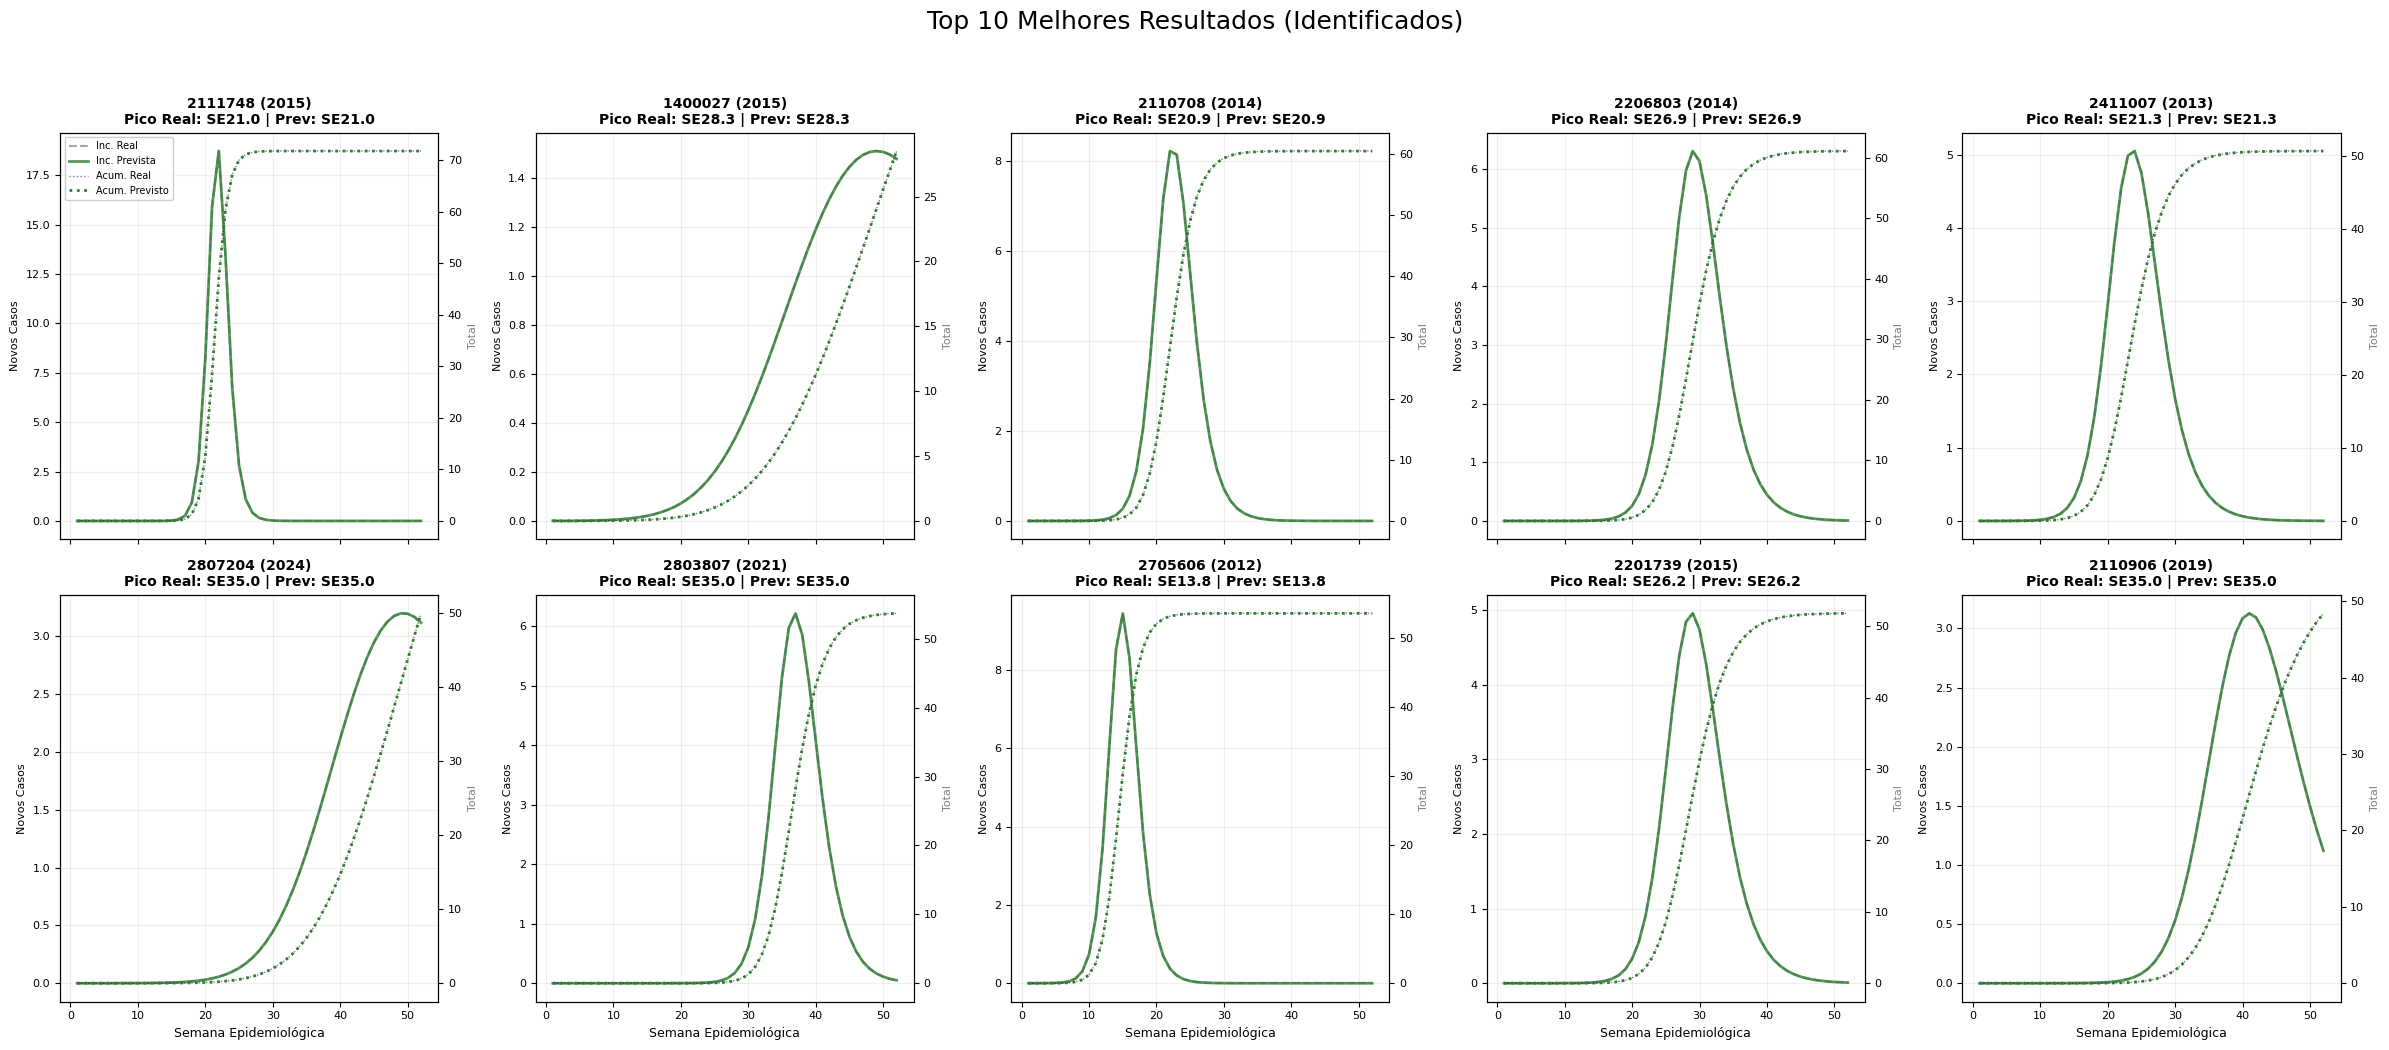


⚠️ Top 10 Piores Previsões:


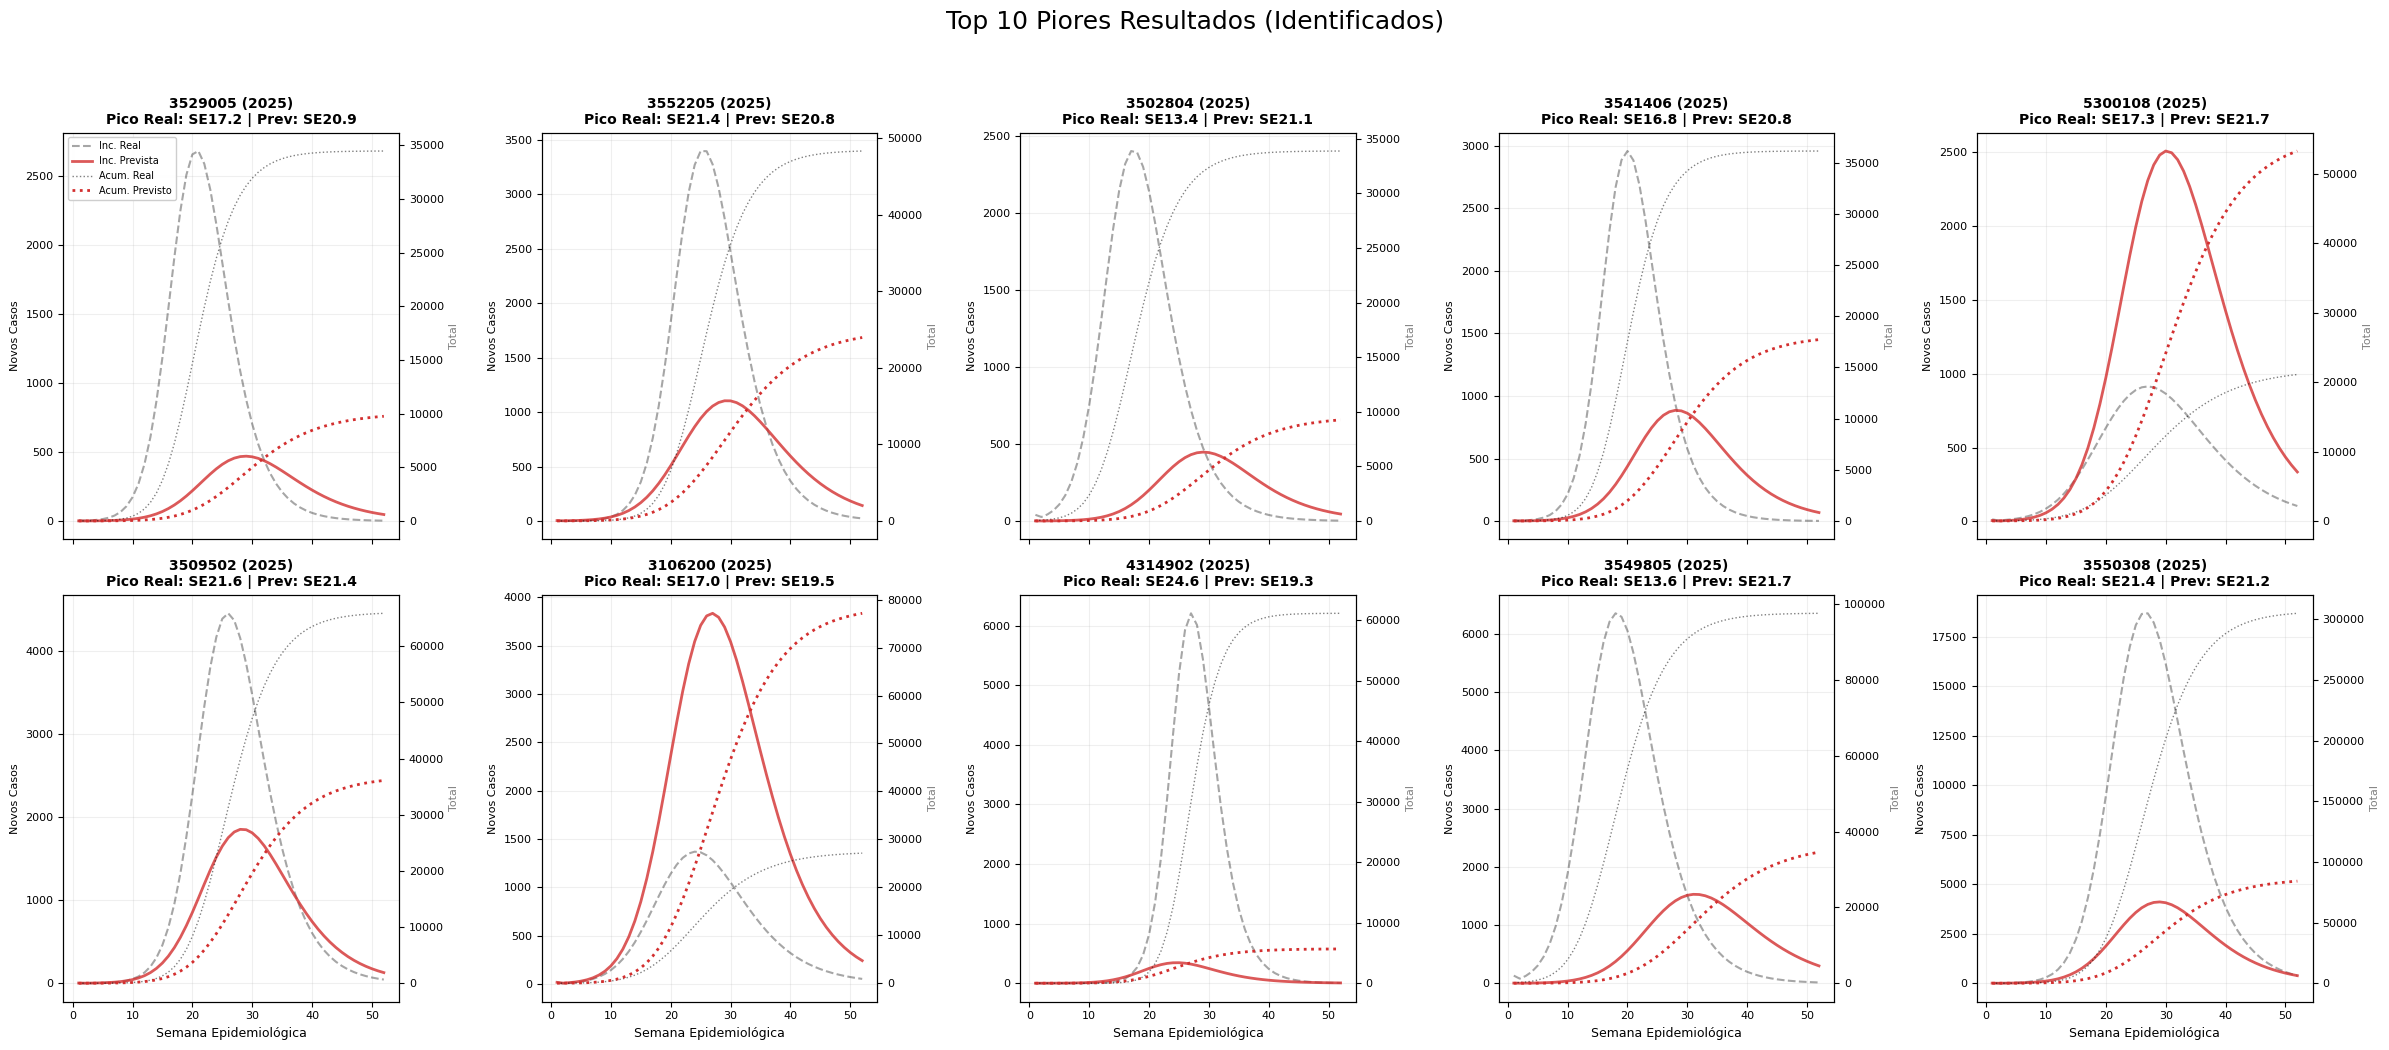

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model(model, dataloader):
    print("🔮 Gerando previsões com índices (Inference)...")

    # Adicionamos return_index=True para saber QUEM é quem (geocode, time_idx)
    raw_predictions = model.predict(dataloader, mode="prediction", return_index=True, return_x=True, return_y=True)

    preds = raw_predictions.output
    targets = raw_predictions.y
    index_df = raw_predictions.index # DataFrame com colunas ['time_idx', 'geocode', ...]

    print("\n📊 MÉTRICAS POR TARGET:")
    results = []

    for i, name in enumerate(TARGETS):
        y_pred = preds[i].cpu().numpy().flatten()
        y_true = targets[0][i].cpu().numpy().flatten()

        if "log_total_cases" in name:
            y_pred = np.expm1(y_pred)
            y_true = np.expm1(y_true)
            metric_name = "Total Cases (Real Scale)"
        else:
            metric_name = name

        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"  🔹 {metric_name:<25} | MAE: {mae:.4f} | R²: {r2:.4f}")
        results.append((y_pred, y_true))

    return preds, targets, index_df
def get_richards_curves(t, L, t_peak, alpha, beta):
    """
    Retorna AMBAS as curvas: Acumulada (J) e Incidência (novos casos).
    """
    t = np.array(t)
    b = beta * alpha
    c = 1.0

    # Expoente com sinal negativo para crescimento
    exponent = -b * (t - t_peak)
    exponent = np.clip(exponent, -100, 100)

    # 1. Curva Acumulada (Sigmoide)
    denom = 1 + c * np.exp(exponent)
    J_t = L * (denom ** (-1.0 / alpha))

    # 2. Curva de Incidência (Derivada discreta)
    incidence = np.diff(J_t, prepend=0)

    return J_t, incidence
# --- 1. FUNÇÕES AUXILIARES (Reaproveitando a lógica corrigida) ---

def get_incidence_curve(t, L, t_peak, alpha, beta):
    """
    Gera a curva de novos casos (Incidência) baseada na Eq. de Richards corrigida.
    """
    # Converter tensores para float python
    if isinstance(L, torch.Tensor): L = L.item()
    if isinstance(t_peak, torch.Tensor): t_peak = t_peak.item()
    if isinstance(alpha, torch.Tensor): alpha = alpha.item()
    if isinstance(beta, torch.Tensor): beta = beta.item()

    t = np.array(t)
    b = beta * alpha
    c = 1.0

    # CORREÇÃO: Sinal negativo no expoente para crescimento logístico
    exponent = -b * (t - t_peak)
    exponent = np.clip(exponent, -100, 100)

    # Curva Acumulada J(t)
    denom = 1 + c * np.exp(exponent)
    J_t = L * (denom ** (-1.0 / alpha))

    # Incidência = J(t) - J(t-1)
    incidence = np.diff(J_t, prepend=0)
    return incidence

def calculate_all_errors(preds, targets, target_names):
    """
    Calcula o erro da curva para todas as amostras do teste.
    Retorna uma lista de tuplas: (indice, erro_medio)
    """
    errors = []
    num_samples = len(preds[0])
    weeks = np.arange(1, 53)

    print(f"🔄 Calculando erros para {num_samples} amostras de teste...")

    # --- CORREÇÃO CRÍTICA AQUI ---
    # Movemos os tensores inteiros da GPU para a CPU de uma vez só.
    # .detach() remove do grafo de gradiente (economiza RAM)
    # .cpu() move para a memória do sistema
    preds_cpu = [p.detach().cpu() for p in preds]

    # targets é uma tupla (valores, pesos), pegamos o item [0] que são os valores
    targets_cpu = [t.detach().cpu() for t in targets[0]]

    for idx in range(num_samples):
        # Extrair parâmetros
        p_vals = {}
        t_vals = {}

        for i, name in enumerate(target_names):
            # Usamos .item() para pegar o valor escalar puro do Python
            p = preds_cpu[i][idx].item()
            t = targets_cpu[i][idx].item()

            if "log_total_cases" in name:
                p_vals['L'] = np.expm1(p)
                t_vals['L'] = np.expm1(t)
            elif "peak_week" in name:
                p_vals['tp'] = p
                t_vals['tp'] = t
            elif "alpha" in name:
                p_vals['a'] = p
                t_vals['a'] = t
            elif "beta" in name:
                p_vals['b'] = p
                t_vals['b'] = t

        # Gerar Curvas
        curve_pred = get_incidence_curve(weeks, p_vals['L'], p_vals['tp'], p_vals['a'], p_vals['b'])
        curve_true = get_incidence_curve(weeks, t_vals['L'], t_vals['tp'], t_vals['a'], t_vals['b'])

        # Calcular MAE da curva (diferença média de casos por semana)
        mae = np.mean(np.abs(curve_pred - curve_true))
        errors.append((idx, mae))

    return errors


def plot_grid_results(indices, preds, targets, target_names, title, color_pred='red'):
    """
    Plota um grid 2x5 mostrando Incidência (Eixo Esq) e Acumulado (Eixo Dir).
    """
    fig, axes = plt.subplots(2, 5, figsize=(24, 10)) # Aumentei a largura
    fig.suptitle(title, fontsize=18, y=0.98)
    axes = axes.flatten()

    weeks = np.arange(1, 53)

    for i, idx in enumerate(indices):
        ax1 = axes[i]

        # Extrair Parâmetros (Usando .item() para compatibilidade GPU/CPU)
        p_vals, t_vals = {}, {}
        for k, name in enumerate(target_names):
            # Extrai valor escalar seguro
            p = preds[k][idx].item() if isinstance(preds[k][idx], torch.Tensor) else preds[k][idx]
            t = targets[0][k][idx].item() if isinstance(targets[0][k][idx], torch.Tensor) else targets[0][k][idx]

            if "log_total_cases" in name:
                p_vals['L'] = np.expm1(p)
                t_vals['L'] = np.expm1(t)
            elif "peak_week" in name:
                p_vals['tp'] = p
                t_vals['tp'] = t
            elif "alpha" in name:
                p_vals['a'] = p
                t_vals['a'] = t
            elif "beta" in name:
                p_vals['b'] = p
                t_vals['b'] = t

        # Gerar Dados das Curvas
        acc_pred, inc_pred = get_richards_curves(weeks, p_vals['L'], p_vals['tp'], p_vals['a'], p_vals['b'])
        acc_true, inc_true = get_richards_curves(weeks, t_vals['L'], t_vals['tp'], t_vals['a'], t_vals['b'])

        # --- PLOT 1: INCIDÊNCIA (Eixo Esquerdo) ---
        # Real = Linha preta tracejada
        # Previsto = Linha colorida sólida
        l1, = ax1.plot(weeks, inc_true, 'k--', alpha=0.4, label='Incidência Real')
        l2, = ax1.plot(weeks, inc_pred, color=color_pred, linewidth=2, alpha=0.8, label='Incidência Prevista')

        ax1.set_ylabel("Novos Casos", fontsize=9)
        ax1.tick_params(axis='y', labelsize=8)

        # --- PLOT 2: ACUMULADO (Eixo Direito) ---
        ax2 = ax1.twinx()
        # Real = Pontilhado cinza
        # Previsto = Pontilhado colorido
        l3, = ax2.plot(weeks, acc_true, 'k:', linewidth=1.5, alpha=0.5, label='Acumulado Real')
        l4, = ax2.plot(weeks, acc_pred, color=color_pred, linestyle=':', linewidth=2, label='Acumulado Previsto')

        ax2.set_ylabel("Total Acumulado", fontsize=9, color='gray')
        ax2.tick_params(axis='y', labelcolor='gray', labelsize=8)

        # Título com Erro do Pico
        peak_error = abs(p_vals['tp'] - t_vals['tp'])
        total_error_pct = abs(p_vals['L'] - t_vals['L']) / (t_vals['L'] + 1) * 100

        ax1.set_title(f"Amostra {idx}\nErro Pico: {peak_error:.1f} sem | Erro Total: {total_error_pct:.0f}%", fontsize=10, fontweight='bold')
        ax1.grid(True, alpha=0.2)

        # Legenda unificada apenas no primeiro gráfico
        if i == 0:
            lines = [l1, l2, l3, l4]
            labels = [l.get_label() for l in lines]
            ax1.legend(lines, labels, loc='upper left', fontsize=8, framealpha=0.9)

        # Remover ticks X para limpar, exceto na última linha
        if i < 5: ax1.set_xticklabels([])
        else: ax1.set_xlabel("Semana Epidemiológica")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_grid_results(indices, preds, targets, target_names, index_df, original_data, title, color_pred='red'):
    """
    Plota grid com identificação da Cidade e Ano.
    """
    fig, axes = plt.subplots(2, 5, figsize=(24, 11))
    fig.suptitle(title, fontsize=18, y=0.98)
    axes = axes.flatten()

    weeks = np.arange(1, 53)

    # Criar lookup para nomes de cidades se disponível
    # Tenta achar colunas de nome comuns
    name_col = next((c for c in ['geocode_name', 'muni_name', 'city', 'NM_MUNICIP'] if c in original_data.columns), None)

    for i, idx in enumerate(indices):
        ax1 = axes[i]

        # 1. Recuperar Metadados (Cidade e Ano)
        # Pegamos o geocode e time_idx dessa previsão específica
        row_idx = index_df.iloc[idx]
        geo_code = row_idx['geocode']
        t_idx = row_idx['time_idx']

        # Buscamos no dataframe original para pegar o Ano e Nome
        # Filtramos pelo geocode e time_idx (ou próximo se houver gap, mas no teste é exato)
        meta_row = original_data[(original_data['geocode'] == geo_code) & (original_data['time_idx'] == t_idx)]

        if not meta_row.empty:
            year_val = meta_row['year'].values[0]
            city_name = meta_row[name_col].values[0] if name_col else geo_code
        else:
            year_val = "Desc."
            city_name = geo_code

        # 2. Extrair Parâmetros
        p_vals, t_vals = {}, {}
        for k, name in enumerate(target_names):
            p = preds[k][idx].item() if isinstance(preds[k][idx], torch.Tensor) else preds[k][idx]
            t = targets[0][k][idx].item() if isinstance(targets[0][k][idx], torch.Tensor) else targets[0][k][idx]

            if "log_total_cases" in name:
                p_vals['L'] = np.expm1(p)
                t_vals['L'] = np.expm1(t)
            elif "peak_week" in name:
                p_vals['tp'] = p
                t_vals['tp'] = t
            elif "alpha" in name:
                p_vals['a'] = p
                t_vals['a'] = t
            elif "beta" in name:
                p_vals['b'] = p
                t_vals['b'] = t

        # 3. Gerar Curvas
        acc_pred, inc_pred = get_richards_curves(weeks, p_vals['L'], p_vals['tp'], p_vals['a'], p_vals['b'])
        acc_true, inc_true = get_richards_curves(weeks, t_vals['L'], t_vals['tp'], t_vals['a'], t_vals['b'])

        # 4. Plot
        l1, = ax1.plot(weeks, inc_true, 'k--', alpha=0.35, label='Incidência Real')
        l2, = ax1.plot(weeks, inc_pred, color=color_pred, linewidth=2, alpha=0.8, label='Incidência Prevista')

        ax2 = ax1.twinx()
        l3, = ax2.plot(weeks, acc_true, 'k:', linewidth=1, alpha=0.5, label='Acumulado Real')
        l4, = ax2.plot(weeks, acc_pred, color=color_pred, linestyle=':', linewidth=2, label='Acumulado Previsto')

        # Título Rico com Metadados
        # Quebra o nome da cidade se for muito longo
        city_display = (city_name[:20] + '..') if len(str(city_name)) > 20 else city_name

        header = f"{city_display} ({year_val})\n"
        stats = f"Pico Real: SE{t_vals['tp']:.1f} | Prev: SE{p_vals['tp']:.1f}"

        ax1.set_title(header + stats, fontsize=10, fontweight='bold')

        # Eixos e Grid
        ax1.set_ylabel("Novos Casos", fontsize=8)
        ax2.set_ylabel("Total", fontsize=8, color='gray')
        ax1.grid(True, alpha=0.2)
        ax1.tick_params(labelsize=8)
        ax2.tick_params(labelsize=8)

        # Legenda Limpa (Apenas no primeiro plot)
        if i == 0:
            lines = [l1, l2, l3, l4]
            labels = ["Inc. Real", "Inc. Prevista", "Acum. Real", "Acum. Previsto"]
            ax1.legend(lines, labels, loc='upper left', fontsize=7, framealpha=0.95)

        if i < 5: ax1.set_xticklabels([])
        else: ax1.set_xlabel("Semana Epidemiológica", fontsize=9)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 2. EXECUÇÃO ---

# 1. Calcular erros de todas as amostras
# (Assumindo que 'predictions' e 'ground_truth' já existem do passo anterior)
predictions, ground_truth, prediction_index = evaluate_model(best_tft, val_dataloader)

# 2. Recalcular erros (Se necessário)
if 'all_errors' not in locals():
    all_errors = calculate_all_errors(predictions, ground_truth, TARGETS)
    sorted_errors = sorted(all_errors, key=lambda x: x[1])
    best_10_indices = [x[0] for x in sorted_errors[:10]]
    worst_10_indices = [x[0] for x in sorted_errors[-10:]]

# 3. Plotar Melhores com Nomes
print(f"\n🏆 Top 10 Melhores Previsões:")
plot_grid_results(
    best_10_indices,
    predictions,
    ground_truth,
    TARGETS,
    prediction_index, # <--- Passamos o índice aqui
    data,             # <--- Passamos o dataframe original para lookup
    title="Top 10 Melhores Resultados (Identificados)",
    color_pred='#2E7D32'
)

# 4. Plotar Piores com Nomes
print(f"\n⚠️ Top 10 Piores Previsões:")
plot_grid_results(
    worst_10_indices,
    predictions,
    ground_truth,
    TARGETS,
    prediction_index,
    data,
    title="Top 10 Piores Resultados (Identificados)",
    color_pred='#D32F2F'
)

In [32]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
from pytorch_forecasting import TimeSeriesDataSet

# --- FUNÇÃO 1: VISUALIZAR APENAS O CONJUNTO NÃO VISTO (VALIDAÇÃO) ---

def visualize_unseen_validation(model, val_dataloader, original_data, n=5):
    """
    Plota previsões aleatórias extraídas EXCLUSIVAMENTE do Dataloader de Validação.
    """
    print(f"🔮 Gerando previsões no conjunto de VALIDAÇÃO (n={n})...")

    # 1. Gerar Previsões (Inference)
    # Retorna: output (previsões), x (inputs), index (ids das linhas)
    raw_predictions = model.predict(val_dataloader, mode="prediction", return_index=True, return_x=True, return_y=True)

    preds = raw_predictions.output
    targets = raw_predictions.y
    index_df = raw_predictions.index

    # 2. Selecionar índices aleatórios
    total_samples = len(index_df)
    if total_samples == 0:
        print("⚠️ O dataset de validação está vazio. Verifique o corte de tempo.")
        return

    random_indices = random.sample(range(total_samples), min(n, total_samples))

    # 3. Plotar usando a função de grid que já criamos (reutilizando lógica)
    # (Certifique-se de que a função plot_grid_results do passo anterior está carregada)
    plot_grid_results(
        indices=random_indices,
        preds=preds,
        targets=targets,
        target_names=TARGETS, # Variável global definida anteriormente
        index_df=index_df,
        original_data=original_data,
        title=f"Previsões em Dados Não Vistos (Validação) - {n} Exemplos Aleatórios",
        color_pred='#9C27B0' # Roxo para diferenciar
    )

# --- FUNÇÃO 2: PREVER O PRÓXIMO ANO (FORECAST PURO) ---

def forecast_next_season(model, data, known_reals, unknown_reals, statics, targets):
    """
    Versão Corrigida: Usa model.dataset_parameters para reconstruir os encoders.
    """
    print("🚀 Preparando dados para prever a PRÓXIMA TEMPORADA (Versão Final)...")

    # 1. Descobrir qual é o "Presente" real
    max_time_idx = data['time_idx'].max()
    current_year = data[data['time_idx'] == max_time_idx]['year'].mode()[0]
    print(f"📅 Ano de referência mais recente nos dados: {current_year}")

    # 2. FILTRAGEM DE CIDADES ATIVAS
    recent_threshold = max_time_idx - 4
    active_cities = data[data['time_idx'] >= recent_threshold]['geocode'].unique()

    print(f"   - Total de cidades no banco: {data['geocode'].nunique()}")
    print(f"   - Cidades ativas recentemente (serão previstas): {len(active_cities)}")

    history_window = 60
    data_active = data[
        (data['geocode'].isin(active_cities)) &
        (data['time_idx'] > max_time_idx - history_window)
    ].copy()

    # 3. CRIAR O FUTURO (Decoder)
    last_entries = data_active.sort_values("time_idx").groupby("geocode").tail(1).copy()

    future_df = last_entries.copy()

    # Avançar Tempo
    future_df["time_idx"] += 1

    # Lógica de Virada de Ano
    future_df.loc[future_df['month'] == 12, 'year'] += 1
    future_df.loc[future_df['month'] == 12, 'month'] = 1
    future_df.loc[future_df['month'] != 1, 'month'] += 1

    # Zerar Variáveis Desconhecidas
    for col in ["casos", "incidence", "tda_entropy_H1", "tda_amplitude_H1"]:
        if col in future_df.columns:
            future_df[col] = 0.0

    # 4. JUNTAR HISTÓRICO + FUTURO
    inference_data = pd.concat([data_active, future_df], ignore_index=True)
    inference_data = inference_data.sort_values(['geocode', 'time_idx']).reset_index(drop=True)

    print(f"🔮 Gerando Dataloader para {len(active_cities)} cidades...")

    # --- CORREÇÃO AQUI ---
    # Em vez de from_dataset(model.dataset...), usamos from_parameters
    # Isso garante que usamos os MESMOS encoders do treino
    inference_dataset = TimeSeriesDataSet.from_parameters(
        model.dataset_parameters,
        inference_data,
        predict=True,
        stop_randomization=True
    )

    inf_dataloader = inference_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

    # 5. PREVER
    # return_index=True é vital para saber qual previsão pertence a qual cidade
    raw_predictions = model.predict(inf_dataloader, mode="prediction", return_index=True)
    preds = raw_predictions.output
    index = raw_predictions.index

    # 6. FORMATAR SAÍDA
    results = pd.DataFrame()
    results['geocode'] = index['geocode']

    # Tenta pegar o ano do futuro que criamos
    # Fazemos um merge rápido para pegar o ano correspondente ao time_idx previsto
    # O time_idx da previsão é o último do input (decoder)
    future_years = future_df[['geocode', 'time_idx', 'year']].rename(columns={'year': 'Forecast_Year'})
    results = results.merge(future_years, on=['geocode'], how='left') # Merge simplificado pelo geocode pois só tem 1 futuro por cidade

    # Extrair valores
    # preds é uma lista de tensores [R0, Peak, Total, Alpha, Beta]
    results['Pred_R0'] = preds[0].cpu().numpy().flatten()
    results['Pred_Peak_Week'] = preds[1].cpu().numpy().flatten()
    results['Pred_Total_Cases'] = np.expm1(preds[2].cpu().numpy().flatten())

    if len(preds) > 3:
        results['Pred_Alpha'] = preds[3].cpu().numpy().flatten()
        results['Pred_Beta'] = preds[4].cpu().numpy().flatten()

    print("✅ Previsão Concluída!")
    return results

def plot_future_forecast(results_df, n=3):
    """
    Desenha a curva prevista para o futuro (sem dados reais para comparar, pois é o futuro!).
    """
    sample = results_df.sample(n)
    weeks = np.arange(1, 53)

    plt.figure(figsize=(15, 5))

    for i, (idx, row) in enumerate(sample.iterrows()):
        L = row['Pred_Total_Cases']
        tp = row['Pred_Peak_Week']
        a = row['Pred_Alpha']
        b = row['Pred_Beta']

        # Calcular Curva de Incidência (Novos Casos)
        # Usando a função richards_curve_diff definida anteriormente
        # Lembre-se: richards_cumulative é a acumulada, aqui queremos a diária/semanal

        # Recriando logica rapida de incidencia se nao tiver a funcao importada
        # (Idealmente use a função que já definimos no bloco anterior)
        # Mas vou usar a get_richards_curves para garantir
        _, inc = get_richards_curves(weeks, L, tp, a, b)

        city = row['geocode_name'] if 'geocode_name' in row else row['geocode']

        plt.subplot(1, 3, i+1)
        plt.plot(weeks, inc, color='#FF5722', linewidth=2.5, label='Previsão 2025/26')
        plt.title(f"{city}\nR0: {row['Pred_R0']:.2f} | Pico: SE{tp:.1f}")
        plt.xlabel("Semana Epidemiológica Futura")
        plt.ylabel("Casos Previstos")
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🔮 Gerando previsões no conjunto de VALIDAÇÃO (n=10)...


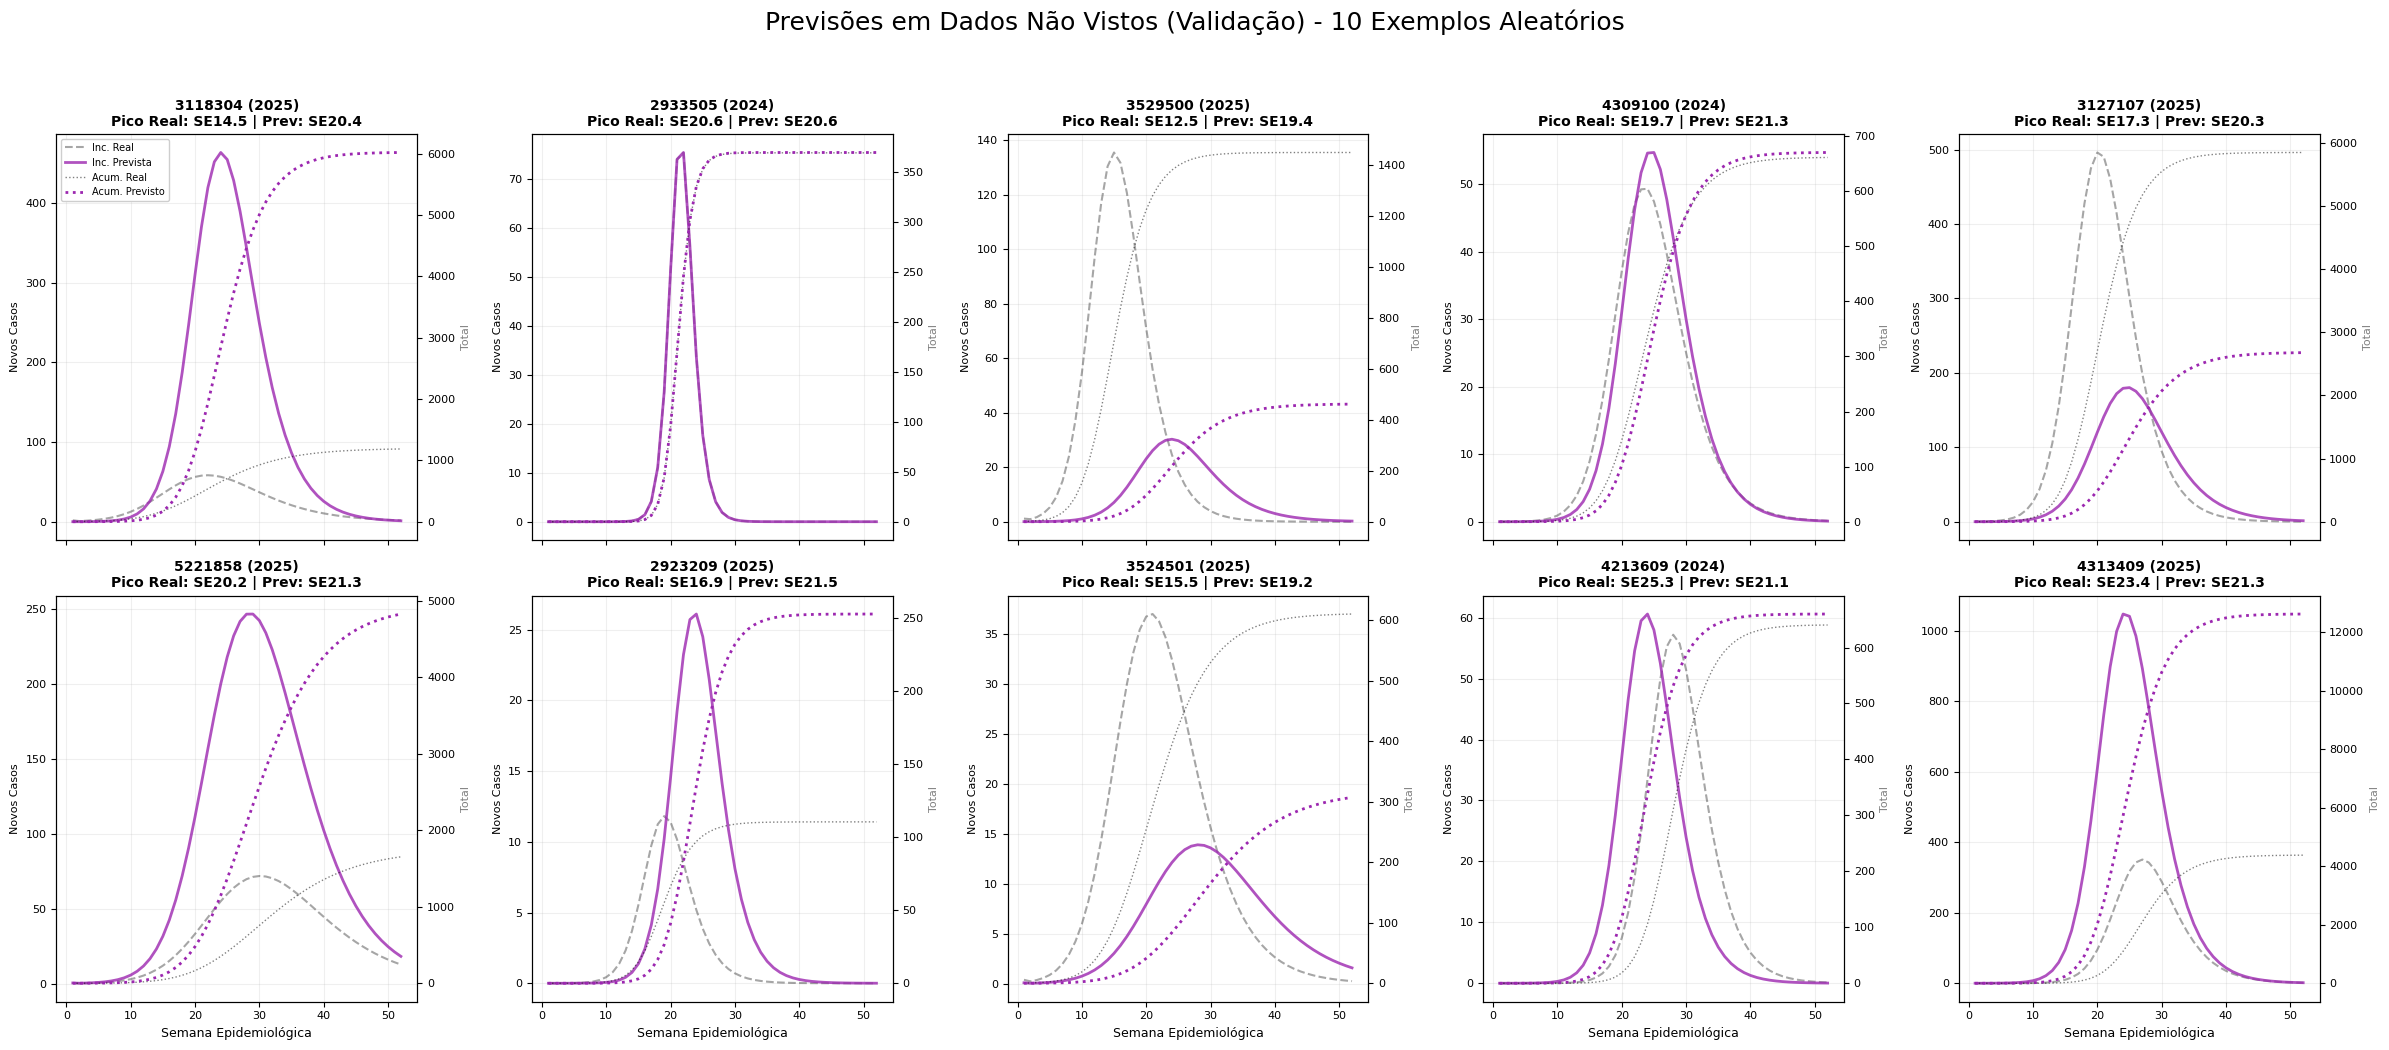

In [30]:
# Chama a função que criamos agora
visualize_unseen_validation(best_tft, val_dataloader, data, n=10)

In [33]:
# 1. Carregar dados COMPLETOS (sem filtrar pelos Targets que queremos prever)
print("📂 Carregando dataset completo para inferência...")
data_full = pd.read_parquet(DATA_PATH)

# Garantir tipos
data_full["time_idx"] = data_full["time_idx"].astype(int)
data_full["geocode"] = data_full["geocode"].astype(str)
for col in STATIC_CATEGORICALS:
    if col in data_full.columns:
        data_full[col] = data_full[col].astype(str)

# 2. Filtrar apenas colunas de INPUT (ignorando se R0/Pico são nulos)
# Precisamos garantir que temos Casos, Clima e População não nulos
input_cols = TIME_VARYING_KNOWN_REALS + TIME_VARYING_UNKNOWN_REALS + STATIC_REALS
input_cols = [c for c in input_cols if c in data_full.columns]

# Limpeza leve (apenas se faltar input essencial)
data_inference = data_full.dropna(subset=input_cols).copy()

print(f"📅 Último ano disponível nos dados: {data_inference['year'].max()}")
# Agora deve mostrar 2024 ou 2025

# 3. Rodar a previsão usando esse dataframe completo
future_results = forecast_next_season(
    best_tft,
    data_inference, # <--- Use este dataframe novo
    TIME_VARYING_KNOWN_REALS,
    TIME_VARYING_UNKNOWN_REALS,
    STATIC_CATEGORICALS,
    TARGETS
)

display(future_results.head())

📂 Carregando dataset completo para inferência...
📅 Último ano disponível nos dados: 2025
🚀 Preparando dados para prever a PRÓXIMA TEMPORADA (Versão Final)...
📅 Ano de referência mais recente nos dados: 2025
   - Total de cidades no banco: 4659
   - Cidades ativas recentemente (serão previstas): 2217
🔮 Gerando Dataloader para 2217 cidades...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


✅ Previsão Concluída!


,geocode,time_idx,Forecast_Year,Pred_R0,Pred_Peak_Week,Pred_Total_Cases,Pred_Alpha,Pred_Beta
0,1100015,804,2025,1.536521,16.538742,449.243011,0.354888,0.466274
1,1100023,804,2025,1.460823,16.558205,630.126892,0.320512,0.448577
2,1100031,804,2025,1.782656,16.720175,100.415550,0.443304,0.544895
3,1100056,804,2025,1.851339,15.564276,393.278290,0.460322,0.550284
4,1100072,804,2025,2.004720,17.080132,85.947655,0.515960,0.600621


In [34]:
# see max forecast_year of future_results
print(f"Max Forecast Year: {future_results['Forecast_Year'].max()}")


Max Forecast Year: 2025


In [35]:
data_full

,date,epiweek,geocode,casos,uf,macroregional_geocode,regional_geocode,train_1,target_1,train_2,target_2,train_3,target_3,year,month,time_idx,week_of_year,week_cycle,sin_week_cycle,cos_week_cycle,temp_min,temp_med,temp_max,precip_min,precip_med,precip_max,pressure_min,pressure_med,pressure_max,rel_humid_min,rel_humid_med,rel_humid_max,thermal_range,rainy_days,enso,iod,pdo,forecast_temp_med,forecast_umid_med,forecast_precip_tot,population,log_pop,uf_code,koppen,biome,macroregion_name,regional_name,R0,peak_week,total_cases,alpha,beta,log_total_cases,incidence,tda_entropy_H0,tda_entropy_H1,tda_amplitude_H0,tda_amplitude_H1,num_neighbors
0,2011-01-02,201101,1100015,0,RO,1101,11005,True,False,True,False,True,False,2011,1,52,1,13,1.000000,-1.608123e-16,22.194815,24.659414,28.058685,3.9964,32.489300,93.736198,0.964657,0.967329,0.969343,74.534370,89.036514,98.058189,5.863872,7.0,-1.672813,-2.588832,-0.536525,25.392178,85.819191,0.000104,24947.0,10.124549,11,Am,Amazônia,Norte,ZONA DA MATA,1.956119,8.519794,120.271545,0.488784,0.597537,4.798032,0.000000,0.000000,0.000000,0.000000,0.000000,2
1,2011-01-09,201102,1100015,0,RO,1101,11005,True,False,True,False,True,False,2011,1,53,2,14,0.992709,-1.205367e-01,23.102514,25.861757,29.373228,0.8215,15.186200,46.449902,0.964986,0.967971,0.970143,68.326416,84.865814,95.099289,6.270714,7.0,-1.692035,-3.296357,0.048750,25.392178,85.819191,0.000104,24947.0,10.124549,11,Am,Amazônia,Norte,ZONA DA MATA,1.956119,8.519794,120.271545,0.488784,0.597537,4.798032,0.000000,0.000000,0.000000,0.000000,0.000000,2
2,2011-01-16,201103,1100015,2,RO,1101,11005,True,False,True,False,True,False,2011,1,54,3,15,0.970942,-2.393157e-01,22.708115,24.887714,28.102085,1.8265,28.807301,84.472000,0.964643,0.967186,0.969157,73.723328,87.587212,96.401672,5.393971,7.0,-1.804757,-3.169202,-0.087791,25.392178,85.819191,0.000104,24947.0,10.124549,11,Am,Amazônia,Norte,ZONA DA MATA,1.956119,8.519794,120.271545,0.488784,0.597537,4.798032,8.016996,0.000000,0.000000,0.000000,0.000000,2
3,2011-01-23,201104,1100015,0,RO,1101,11005,True,False,True,False,True,False,2011,1,55,4,16,0.935016,-3.546049e-01,22.099928,24.397657,28.119286,5.6922,26.469900,80.710899,0.966786,0.969343,0.971457,72.976128,89.072227,98.124985,6.019357,7.0,-1.804757,-3.169202,-0.087791,25.392178,85.819191,0.000104,24947.0,10.124549,11,Am,Amazônia,Norte,ZONA DA MATA,1.956119,8.519794,120.271545,0.488784,0.597537,4.798032,0.000000,0.000000,0.000000,0.000000,0.000000,2
4,2011-01-30,201105,1100015,0,RO,1101,11005,True,False,True,False,True,False,2011,1,56,5,17,0.885456,-4.647232e-01,22.840042,25.728371,29.895243,1.1087,16.936800,52.370998,0.966500,0.970043,0.972143,65.774788,84.786118,96.114159,7.055200,7.0,-1.804757,-3.169202,-0.087791,25.392178,85.819191,0.000104,24947.0,10.124549,11,Am,Amazônia,Norte,ZONA DA MATA,1.956119,8.519794,120.271545,0.488784,0.597537,4.798032,0.000000,0.000000,0.000000,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322418,2025-04-27,202518,5300108,354,DF,5302,53001,False,False,False,False,False,True,2025,4,799,18,30,-0.464723,-8.854560e-01,18.991833,22.945667,27.115700,0.1016,1.819300,8.856700,0.885833,0.887567,0.889133,59.412102,76.983597,91.246635,8.123867,3.0,-0.807978,-1.394405,0.351848,23.140579,75.708412,0.000071,NaN,14.908380,53,Aw,Cerrado,Centro-Oeste,DISTRITO FEDERAL,1.435155,17.347301,21854.595703,0.303211,0.430546,9.992212,0.000000,4.031213,1.270999,41.593533,0.421526,0
1322419,2025-05-04,202519,5300108,418,DF,5302,53001,False,False,False,False,False,True,2025,5,800,19,31,-0.568065,-8.229839e-01,18.991833,22.945667,27.115700,0.1016,1.819300,8.856700,0.885833,0.887567,0.889133,59.412102,76.983597,91.246635,8.123867,3.0,-0.807978,-1.394405,0.351848,23.003725,67.952217,0.000027,NaN,14.908380,53,Aw,Cerrado,Centro-Oeste,DISTRITO FED

In [39]:
import pandas as pd
import numpy as np
import torch
import os
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

# ==========================================
# 1. CONFIGURAÇÕES
# ==========================================
# Ajuste os caminhos conforme seu ambiente
DATA_PATH = ("../data/processed/dataset_inference.parquet")  # O arquivo que geramos no passo anterior

# Variáveis (Devem ser idênticas ao treino)
TARGETS = ["R0", "peak_week", "log_total_cases", "alpha", "beta"]
STATIC_CATEGORICALS = ["uf", "koppen", "biome", "macroregion_name"]
STATIC_REALS = ["num_neighbors"]
TIME_VARYING_KNOWN_REALS = [
    "time_idx", "week_cycle", "sin_week_cycle", "cos_week_cycle", "log_pop",
    "forecast_temp_med", "forecast_precip_tot"
]
TIME_VARYING_UNKNOWN_REALS = [
    "casos", "incidence", "temp_med", "precip_med", "rel_humid_med",
    "enso", "iod", "tda_entropy_H1", "tda_amplitude_H1"
]

# ==========================================
# 2. FUNÇÃO DE PREVISÃO (2025/2026)
# ==========================================
def predict_season_2026(model, data):
    print("🚀 Iniciando Previsão para a Temporada 2025/2026...")

    # 1. Identificar o "Presente" (Último ponto de dados reais)
    max_time_idx = data['time_idx'].max()
    current_year = data['year'].max()
    print(f"📅 Último registro nos dados: Ano {current_year} (Index {max_time_idx})")

    # 2. Filtrar cidades ativas
    # (Pega apenas cidades que têm dados recentes, para evitar prever para cidades 'mortas' de 2010)
    active_threshold = max_time_idx - 10
    active_cities = data[data['time_idx'] >= active_threshold]['geocode'].unique()
    print(f"🏙️ Cidades ativas para previsão: {len(active_cities)}")

    # Pegamos o histórico recente (Encoder) dessas cidades
    # O TFT precisa de pelo menos 'min_encoder_length' (20) semanas de histórico
    history_window = 60
    data_history = data[
        (data['geocode'].isin(active_cities)) &
        (data['time_idx'] > max_time_idx - history_window)
    ].copy()

    # 3. Criar o "Futuro" (Decoder)
    # Para prever a temporada 2026, precisamos criar uma linha de tempo nova
    # Vamos pegar a última linha de cada cidade e avançar 1 passo no tempo
    # Isso simula o "início" da nova temporada

    last_rows = data_history.sort_values("time_idx").groupby("geocode").tail(1).copy()
    future_df = last_rows.copy()

    # A. Atualizar Tempo
    future_df["time_idx"] += 1
    future_df["year"] = current_year + 1 # Joga para 2025/26

    # B. Zerar Variáveis Desconhecidas (Cold Start)
    # Como é o futuro, não sabemos os casos nem a topologia ainda.
    # O modelo vai ter que chutar baseado no clima/estáticos.
    for col in TIME_VARYING_UNKNOWN_REALS:
        if col in future_df.columns:
            future_df[col] = 0.0

    # C. Atualizar Variáveis Conhecidas (Sazonalidade)
    # Avança o ciclo semanal (simulação simples)
    # Se quiser ser preciso, teria que recalcular sin/cos da semana real
    # Aqui mantemos a continuidade do ciclo anterior
    future_df["week_cycle"] = future_df["week_cycle"].apply(lambda x: x + 1 if x < 52 else 1)
    future_df["sin_week_cycle"] = np.sin(2 * np.pi * future_df["week_cycle"] / 52)
    future_df["cos_week_cycle"] = np.cos(2 * np.pi * future_df["week_cycle"] / 52)

    # 4. Juntar Histórico + Futuro
    inference_data = pd.concat([data_history, future_df], ignore_index=True)
    inference_data = inference_data.sort_values(['geocode', 'time_idx']).reset_index(drop=True)

    # 5. Criar Dataloader
    print("🔮 Gerando Dataloader de Inferência...")

    # --- CORREÇÃO DO ATRIBUTO DATASET ---
    # Usamos from_dataset passando model.dataset_parameters (config interna salva)
    # ou recriamos manualmente se parameters falhar (fallback seguro)
    try:
        inference_dataset = TimeSeriesDataSet.from_parameters(
            model.dataset_parameters,
            inference_data,
            predict=True,
            stop_randomization=True
        )
    except AttributeError:
        # Fallback: Se o modelo não tiver parameters expostos, recriamos com as configs globais
        print("⚠️ Aviso: Usando recriação manual do dataset (Fallback)...")
        # Precisamos de um normalizador dummy (igual ao treino)
        from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer
        target_normalizer = MultiNormalizer([
            GroupNormalizer(groups=["geocode"], transformation="softplus"), # R0
            GroupNormalizer(groups=["geocode"], transformation="softplus"), # Peak
            GroupNormalizer(groups=["geocode"], transformation=None),       # Total
            GroupNormalizer(groups=["geocode"], transformation="logit"),    # Alpha
            GroupNormalizer(groups=["geocode"], transformation="softplus")  # Beta
        ])

        inference_dataset = TimeSeriesDataSet(
            inference_data,
            time_idx="time_idx",
            target=TARGETS,
            group_ids=["geocode"],
            min_encoder_length=20, max_encoder_length=52,
            min_prediction_length=1, max_prediction_length=1,
            static_categoricals=STATIC_CATEGORICALS,
            static_reals=STATIC_REALS,
            time_varying_known_reals=TIME_VARYING_KNOWN_REALS,
            time_varying_unknown_reals=TIME_VARYING_UNKNOWN_REALS,
            target_normalizer=target_normalizer,
            allow_missing_timesteps=True,
            predict_mode=True
        )

    inf_dataloader = inference_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

    # 6. Previsão
    print("🧠 Executando a Rede Neural...")
    raw_predictions = model.predict(inf_dataloader, mode="prediction", return_index=True)
    preds = raw_predictions.output
    index = raw_predictions.index

    # 7. Organizar Resultados
    results = pd.DataFrame()
    results['geocode'] = index['geocode']
    results['Forecast_Year'] = future_df['year'].iloc[0] # Ano previsto

    # Extrair valores dos tensores
    results['Pred_R0'] = preds[0].cpu().numpy().flatten()
    results['Pred_Peak_Week'] = preds[1].cpu().numpy().flatten()
    results['Pred_Total_Cases_Log'] = preds[2].cpu().numpy().flatten()
    results['Pred_Total_Cases'] = np.expm1(results['Pred_Total_Cases_Log']).astype(int)

    if len(preds) > 3:
        results['Pred_Alpha'] = preds[3].cpu().numpy().flatten()
        results['Pred_Beta'] = preds[4].cpu().numpy().flatten()

    # Adicionar nomes se disponíveis
    if 'geocode_name' in data.columns:
        names = data[['geocode', 'geocode_name', 'uf']].drop_duplicates()
        results = results.merge(names, on='geocode', how='left')

    print("✅ Previsões Geradas com Sucesso!")
    return results

def filter_known_cities(model, df_inference):
    print("🧹 Filtrando cidades desconhecidas pelo modelo...")

    # 1. Recuperar a lista de cidades que o modelo aprendeu no treino
    # O modelo guarda os encoders dentro de 'dataset_parameters'
    try:
        geocode_encoder = model.dataset_parameters["categorical_encoders"]["geocode"]

        # .classes_ contém a lista de todos os geocodes vistos no treino
        known_geocodes = set(geocode_encoder.classes_)

        # O encoder pode ter mapeado strings, garantimos a conversão
        known_geocodes = {str(g) for g in known_geocodes}

    except KeyError:
        print("⚠️ Aviso: Encoder de geocode não encontrado. Pulando filtro (pode dar erro).")
        return df_inference

    # 2. Filtrar o dataframe
    total_cities = df_inference['geocode'].nunique()

    # Mantém apenas o que está no set known_geocodes
    df_filtered = df_inference[df_inference['geocode'].astype(str).isin(known_geocodes)].copy()

    remaining_cities = df_filtered['geocode'].nunique()
    removed = total_cities - remaining_cities

    print(f"   - Cidades no arquivo total: {total_cities}")
    print(f"   - Cidades conhecidas pelo modelo: {remaining_cities}")
    print(f"   - Cidades removidas (Nunca tiveram epidemia no treino): {removed}")

    return df_filtered

# --- ATUALIZAÇÃO DA FUNÇÃO MAIN ---

def main_inference():
    # ... (Carregamento do modelo igual antes) ...
    if not os.path.exists(CHECKPOINT_DIR): return None
    ckpts = [os.path.join(CHECKPOINT_DIR, f) for f in os.listdir(CHECKPOINT_DIR) if f.endswith(".ckpt")]
    latest_ckpt = max(ckpts, key=os.path.getctime)
    best_tft = TemporalFusionTransformer.load_from_checkpoint(latest_ckpt, map_location="cpu", weights_only=False)

    # ... (Carregamento dos dados igual antes) ...
    df_inf = pd.read_parquet(DATA_PATH)

    # Garantir Tipos
    df_inf["time_idx"] = df_inf["time_idx"].astype(int)
    df_inf["geocode"] = df_inf["geocode"].astype(str)
    for col in STATIC_CATEGORICALS:
        if col in df_inf.columns:
            df_inf[col] = df_inf[col].astype(str)

    # --- APLICAÇÃO DO FILTRO AQUI ---
    df_inf_filtered = filter_known_cities(best_tft, df_inf)

    # 3. Rodar Previsão com o dataset filtrado
    forecast_df = predict_season_2026(best_tft, df_inf_filtered)

    return forecast_df

In [40]:
df_2026 = main_inference()

if df_2026 is not None:
    print("\n📊 Top 10 Cidades com Maior Risco (R0) para 2026:")
    display(df_2026.sort_values('Pred_R0', ascending=False).head(10))

    # Salvar
    df_2026.to_csv("previsoes_dengue_2026.csv", index=False)
    print("💾 Resultados salvos em 'previsoes_dengue_2026.csv'")

🧹 Filtrando cidades desconhecidas pelo modelo...
   - Cidades no arquivo total: 5570
   - Cidades conhecidas pelo modelo: 4659
   - Cidades removidas (Nunca tiveram epidemia no treino): 911
🚀 Iniciando Previsão para a Temporada 2025/2026...
📅 Último registro nos dados: Ano 2025 (Index 803)
🏙️ Cidades ativas para previsão: 4659
🔮 Gerando Dataloader de Inferência...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🧠 Executando a Rede Neural...
✅ Previsões Geradas com Sucesso!

📊 Top 10 Cidades com Maior Risco (R0) para 2026:


,geocode,Forecast_Year,Pred_R0,Pred_Peak_Week,Pred_Total_Cases_Log,Pred_Total_Cases,Pred_Alpha,Pred_Beta
450,2110203,2026,4.332931,13.966090,4.471855,86,0.769189,1.299668
315,1714302,2026,4.332919,11.863174,4.731153,112,0.769188,1.299659
809,2404002,2026,4.330661,18.290573,4.088978,58,0.769068,1.299864
361,2100436,2026,4.330029,16.882765,4.018863,54,0.769035,1.299931
785,2401701,2026,4.327726,26.868246,4.133901,61,0.768912,1.300140
1547,2914208,2026,4.320478,20.773106,5.425487,226,0.768516,1.300734
516,2202737,2026,4.313394,26.690353,4.216023,66,0.768144,1.301430
426,2106755,2026,4.312283,9.925402,6.104460,446,0.768085,1.301523
465,2111748,2026,4.310103,21.037659,4.288628,71,0.767967,1.301738
113,1304302,2026,4.307285,22.712278,4.135890,61,0.767811,1.301963


💾 Resultados salvos em 'previsoes_dengue_2026.csv'


In [44]:
display(df_2026.sort_values('Pred_Total_Cases', ascending=False).head(10))

,geocode,Forecast_Year,Pred_R0,Pred_Peak_Week,Pred_Total_Cases_Log,Pred_Total_Cases,Pred_Alpha,Pred_Beta
3341,3550308,2026,1.495453,21.151428,11.038936,62250,0.331965,0.441868
1850,3106200,2026,1.502277,19.569418,10.966839,57920,0.339124,0.443483
4511,5208707,2026,1.431159,20.373701,10.786453,48360,0.307275,0.426798
4658,5300108,2026,1.456030,21.726887,10.711327,44860,0.318959,0.437172
2757,3304557,2026,1.510746,20.728073,10.616983,40821,0.342125,0.454444
3335,3549805,2026,1.419685,21.658478,10.347333,31172,0.300529,0.421302
647,2304400,2026,1.494786,24.701908,10.279256,29121,0.337905,0.444777
2889,3509502,2026,1.523944,21.416550,10.268686,28815,0.347070,0.450387
3266,3543402,2026,1.523876,19.585424,10.263128,28655,0.348920,0.453207
3600,4113700,2026,1.444715,19.610634,10.058293,23347,0.313647,0.429983


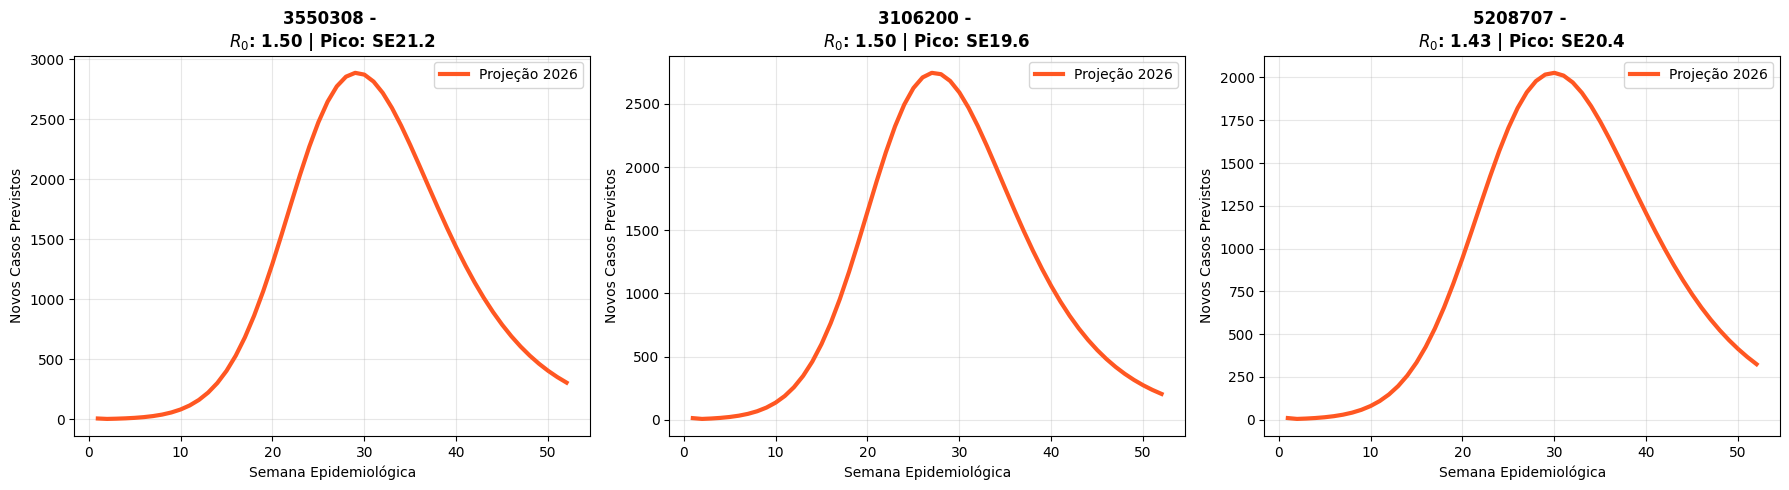

In [45]:
import matplotlib.pyplot as plt

def plot_2026_forecasts(results_df, n=3):
    """Plota as curvas previstas para o futuro."""

    # Seleciona as piores epidemias previstas (maior R0) para mostrar
    top_risks = results_df.sort_values('Pred_Total_Cases', ascending=False).head(n)

    weeks = np.arange(1, 53)

    plt.figure(figsize=(18, 5))

    for i, (idx, row) in enumerate(top_risks.iterrows()):
        # Parâmetros
        L = row['Pred_Total_Cases']
        tp = row['Pred_Peak_Week']
        a = row['Pred_Alpha']
        b = row['Pred_Beta']

        # Reconstruir Curva de Incidência (Derivada de Richards)
        # b_calc = beta * alpha
        b_calc = b * a
        exponent = -b_calc * (weeks - tp)
        denom = 1 + np.exp(np.clip(exponent, -100, 100))
        J_t = L * (denom ** (-1.0 / a))
        inc = np.diff(J_t, prepend=0)

        # Plot
        city_name = row['geocode_name'] if 'geocode_name' in row else row['geocode']
        uf = row['uf'] if 'uf' in row else ""

        plt.subplot(1, n, i+1)
        plt.plot(weeks, inc, color='#FF5722', linewidth=3, label='Projeção 2026')

        title = f"{city_name} - {uf}\n$R_0$: {row['Pred_R0']:.2f} | Pico: SE{tp:.1f}"
        plt.title(title, fontsize=12, fontweight='bold')
        plt.xlabel("Semana Epidemiológica")
        plt.ylabel("Novos Casos Previstos")
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

# Usar após gerar o df_2026
if 'df_2026' in locals() and df_2026 is not None:
    plot_2026_forecasts(df_2026, n=3)